In [1]:
%run '../ipython_startup.py'

Importing commonly used libraries: 
            os, sys 
            numpy as np 
            scipy as sp 
            pandas as pd 
            matplotlib as mp 
            matplotlib.pyplot as plt
            datetime as dt 
            mclib_Python/flagging as fg

Creating project level variables: 
        MCLAB = /home/jfear/mclab 
        PROJ = /home/jfear/mclab/cegs_ase_paper 
        TODAY = 20160113

Adding ['scripts/mclib_Python', 'scripts/ase_Python'] to PYTHONPATH



In [2]:
# Import additional libraries
import sas7bdat as sas
from itertools import combinations
import seaborn

pjoin = os.path.join

/home/jfear/opt/miniconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
with sas.SAS7BDAT(pjoin(PROJ, 'sas_data/cis_eq.sas7bdat')) as FH:
    df = FH.to_data_frame()

[cis_eq.sas7bdat] header length 65536 != 8192


In [7]:
df.head()

,line,mating_status,fusion_id,q5_mean_theta,flag_AI_combined,mean_apn,cis_tester,mu,cis_line,trans_tester,trans_line
0,r324,M,F10001_SI,0.507,0,35.659574,11,0,14,-11,-20.4
1,r365,M,F10001_SI,0.646,0,31.127660,11,0,-37,-11,1.6
2,r373,M,F10001_SI,0.589,0,46.191489,11,0,-55,-11,265.6
3,r427,M,F10001_SI,0.500,0,47.936170,11,0,17,-11,-52.4
4,r491,M,F10001_SI,0.401,0,47.276596,11,0,39,-11,-136.4


In [90]:
mated = df[df['mating_status'] == 'M']
virgin = df[df['mating_status'] == 'V']

In [108]:
def loop(df, func):
    """ This is a general looping function. 
    
    Creates and iterates over all pairwise combinations. Filters 
    dataframe and passes it to the given function. This will make it 
    easy to run various distance metrics.
    
    """
    # get list of lines
    lines = df['line'].factorize()[1]
    
    # Create matrix to store distance results
    dfResults = pd.DataFrame(np.eye(lines.shape[0], lines.shape[0]), columns=lines, index=lines)
    
    #Iterate over all pairwise combinations
    for combo in combinations(lines, 2):
        
        # Create dataframe for current combination
        dfCurr = df[(df['line'] == combo[0]) | (df['line'] == combo[1])]
        
        # Pass dataframe to my function of choice
        res = func(dfCurr)
        
        # Fill in results matrix
        dfResults.loc[combo[0], combo[1]] = res
        dfResults.loc[combo[1], combo[0]] = res

    return dfResults

# AI

Here I use flag_AI_combined from the Bayesian machine to determine pairwise distance. For this calculation I drop all fusions that are not in both datasets (i.e., drop NaN). I then normalize the sum by the number of non-missing fusions, trying to normalize for the number of fusions present in both datasets.

In [109]:
def AI_dist(df):
    # Create a 2 column side-by-side dataframe with fusion_id as rows and lines and columns.
    dfSbs = df[['line', 'fusion_id', 'flag_AI_combined']].set_index(['fusion_id', 'line']).unstack()
    
    # Sum flag_AI_combined across lines, if equals 2 then both lines had AI
    dfSum = dfSbs.sum(axis=1)
    
    # Number of fusions that both had AI
    num = dfSum[dfSum == 2].shape[0]
    
    # How many fusions did we test, after removing NaN
    total = dfSum.dropna().shape[0]
    
    return num / float(total)
    

In [121]:
aiMated = loop(mated, AI_dist)
aiVirgin = loop(virgin, AI_dist)

In [113]:
aiMated.head()

,r324,r365,r373,r427,r491,r799,w47,w52,w55,w64,...,r362,r392,r810,r853,r907,w67,r443,r502,r857,r426
r324,1.000000,0.042489,0.059631,0.054994,0.052315,0.048092,0.077101,0.081869,0.086939,0.056840,...,0.016511,0.017346,0.026632,0.027613,0.032829,0.036356,0.017920,0.025821,0.039140,0.020327
r365,0.042489,1.000000,0.031518,0.033045,0.032922,0.035348,0.042578,0.038778,0.044643,0.034603,...,0.015880,0.011573,0.019426,0.025147,0.022611,0.020940,0.015132,0.016883,0.028390,0.019130
r373,0.059631,0.031518,1.000000,0.039458,0.050292,0.035234,0.056265,0.059614,0.052377,0.045418,...,0.017552,0.018182,0.029703,0.030627,0.039137,0.035354,0.016566,0.028354,0.042352,0.025141
r427,0.054994,0.033045,0.039458,1.000000,0.042039,0.041808,0.058644,0.048723,0.052773,0.036224,...,0.018541,0.014780,0.025769,0.025051,0.036287,0.022746,0.010998,0.023689,0.033806,0.021413
r491,0.052315,0.032922,0.050292,0.042039,1.000000,0.036925,0.054643,0.053045,0.054138,0.040541,...,0.013147,0.012674,0.026072,0.022360,0.028656,0.024452,0.013514,0.019848,0.036044,0.019717


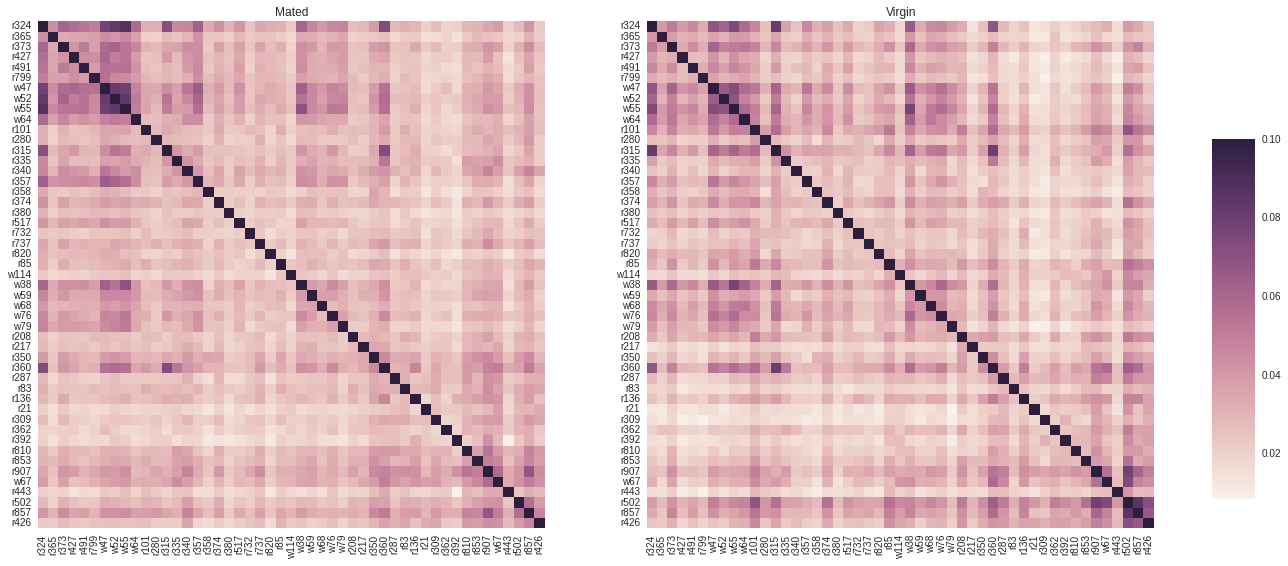

In [139]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
cbar_ax = fig.add_axes([.94, .2, .03, .5])

seaborn.heatmap(aiMated, vmax=0.1, square=True, ax=ax1, cbar=False)
ax1.set_title('Mated')

seaborn.heatmap(aiVirgin, vmax=0.1, square=True, ax=ax2, cbar_ax=cbar_ax)
ax2.set_title('Virgin')

# Cis Direction

Calculate distance based on direction of the cis-effect. If direction is them same then flag = 1, else = 0. Come up with my distance metric by dividing the sum by the total number of fusions tested (i.e., no missing).

In [152]:
def cis_direction_dist(df):
    # Create a 2 column side-by-side dataframe with fusion_id as rows and lines and columns.
    dfSbs = df[['line', 'fusion_id', 'cis_line']].set_index(['fusion_id', 'line']).unstack()
    
    # Drop missing
    noMiss = dfSbs.dropna()
    
    # If both have a positive or negative cis effects
    flag = ((noMiss.iloc[0] > 0) & (noMiss.iloc[1] > 0)) | ((noMiss.iloc[0] < 0) & (noMiss.iloc[1] < 0))
    
    # Number in same direction
    num = flag.sum()
    
    # How many fusions did we test, after removing NaN
    total = noMiss.shape[0]
    
    return num / float(total)

In [153]:
cis_direction_Mated = loop(mated, cis_direction_dist)
cis_direction_Virgin = loop(virgin, cis_direction_dist)

In [154]:
cis_direction_Mated.head()

,r324,r365,r373,r427,r491,r799,w47,w52,w55,w64,...,r362,r392,r810,r853,r907,w67,r443,r502,r857,r426
r324,1.000000,0.000602,0.000726,0.001205,0.001206,0.001283,0.000631,0.001337,0.001238,0.001302,...,0.001715,0.000000,0.001908,0.000000,0.001934,0.003861,0.000000,0.002066,0.000000,0.005495
r365,0.000602,1.000000,0.000000,0.000583,0.000592,0.000627,0.000000,0.000670,0.000615,0.000641,...,0.003344,0.002222,0.001887,0.001529,0.001873,0.001972,0.000000,0.001980,0.001597,0.002681
r373,0.000726,0.000000,1.000000,0.000702,0.000701,0.000752,0.000000,0.000772,0.000740,0.000770,...,0.001751,0.002304,0.000000,0.000000,0.000000,0.004016,0.000000,0.004246,0.001639,0.005634
r427,0.001205,0.000583,0.000702,1.000000,0.001170,0.001245,0.000611,0.001300,0.001217,0.001270,...,0.001664,0.004425,0.001890,0.000000,0.001835,0.001961,0.000000,0.004098,0.000000,0.000000
r491,0.001206,0.000592,0.000701,0.001170,1.000000,0.001258,0.000614,0.001316,0.001222,0.001280,...,0.001736,0.002299,0.000000,0.000000,0.003817,0.002024,0.001789,0.002146,0.000000,0.000000


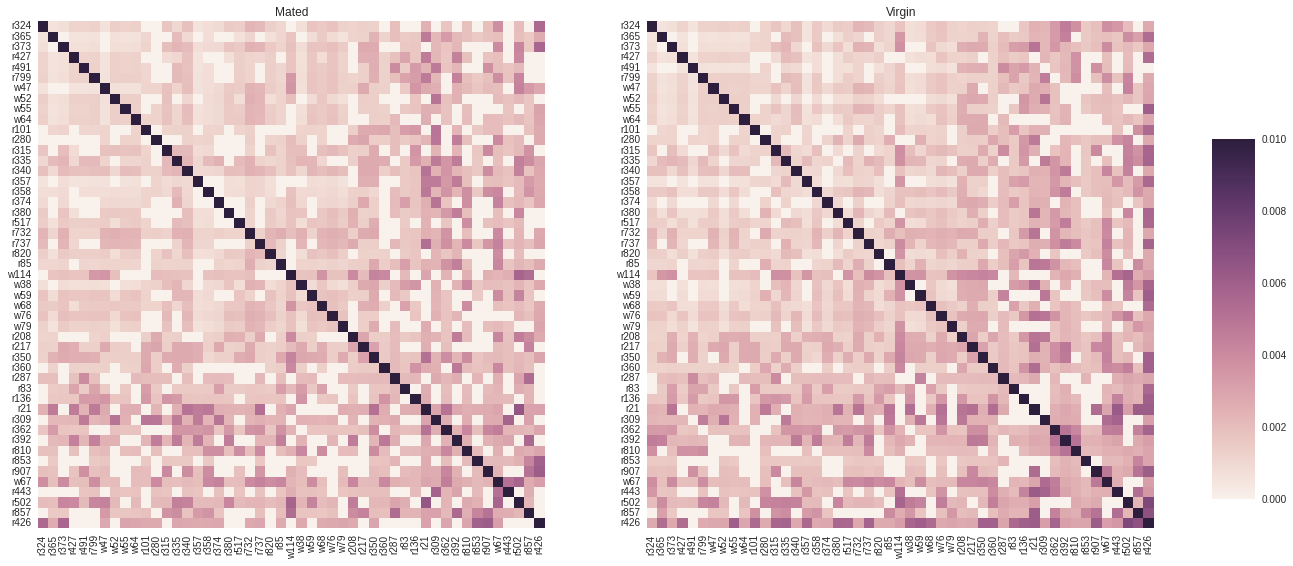

In [155]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
cbar_ax = fig.add_axes([.94, .2, .03, .5])

seaborn.heatmap(cis_direction_Mated, vmax=0.01, square=True, ax=ax1, cbar=False)
ax1.set_title('Mated')

seaborn.heatmap(cis_direction_Virgin, vmax=0.01, square=True, ax=ax2, cbar_ax=cbar_ax)
ax2.set_title('Virgin')